In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import path
import time 
from datetime import datetime 
import math

import sys
import os
import subprocess
import re
import cv2
import mimetypes
import requests
import re

import pickle

In [2]:
data_dir = path.join('..', 'data')
img_dir = path.join(data_dir, 'img')
temp_dir = path.join(data_dir, 'temp')

dataset_file = 'reddit_wsb_art.csv'

data = pd.read_csv(path.join(data_dir, dataset_file))
data = data.sort_values(by=['timestamp'])

In [15]:
RE_HTTP = re.compile("http(s)?://[/\.A-z0-9]+")

def detect_urls(text):
    text = str(text)

    return [str(x[1].group(0)) for x in enumerate(re.finditer(RE_HTTP, text))]

data['body_url'] = data.apply(lambda x: detect_urls(x['body']), axis=1) 
data['body_urls_count'] = data['body_url'].apply(len)

data[['body', 'body_url', 'body_urls_count']].loc[data['body_urls_count'] > 0]

,body,body_url,body_urls_count
11340,"When I saw the video I was in shock, I could n...","[https://www.marketwatch.com/story/gamestop, h...",7
21116,Intel posted earnings today of $1.52 EPS beati...,"[https://preview.redd.it/2lqwp6j4urc61.png, ht...",3
10187,I know the first thing that pops into all of o...,"[https://www.suncor.com/en, https://www.suncor...",5
26804,"Well guys, I lost 90k today on SPY calls which...",[https://imgur.com/8zoihg7\n\n],1
7883,Stocks been up 46% in the past 5 days. They ma...,[https://nypost.com/2020/12/27/danimer],1
...,...,...,...
30079,I don't use the platform to trade but a fellow...,[https://preview.redd.it/5k3fq0h6gyd61.png],1
35388,[https://www.marketwatch.com/story/gamestop-an...,"[https://www.marketwatch.com/story/gamestop, h...",4
2985,"Hello, you rich beautiful degenerates. \n\nLet...","[https://heroicheartsproject.org, https://hunt...",9
17756,https://discord.gg/yc5772JExT,[https://discord.gg/yc5772JExT],1


# Tesseract OCR


In [3]:
class MemeOCR:
    def __init__(self):
        self._white_thresh = 240
        self._tmp_image_fname = './memeocr.jpg'
        self._tmp_txt_base = './memeocr'
        self._tmp_txt_fname = self._tmp_txt_base + '.txt'
        self._template_image = None
        self._keep_tmp_files = False

    def set_template(self, fname):
        self._template_image = self._read_image(fname)

    def recognize(self, fname):
        txt = None
        try:
            img = self._read_image(fname)
            self._thresh_words(img, self._template_image)
            self._exec_tesseract()
            txt = self._read_txt()
            self._delete_tmp_files()
        except:
            txt = ['']
        return txt

    def _read_image(self, fname):
        try:
            img = cv2.imread(fname)
        except IOError:
            img = None
        return img

    def _thresh_words(self, img, template):
#         if img is None:
#             return

#         for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 if all([elem >= self._white_thresh for elem in img[i][j]]):
#                     img[i][j] = (0, 0, 0)
#                 else:
#                     img[i][j] = (255, 255, 255)

        cv2.imwrite(self._tmp_image_fname, img)

    def _exec_tesseract(self):
        subprocess.run([
            'tesseract',
            '-l',
            'eng',
            self._tmp_image_fname,
            self._tmp_txt_base,
        ])

    def _read_txt(self):
#         try:
#             fr = open(self._tmp_txt_fname, encoding='utf-8')
#         except IOError:
#             return None
#         content = fr.read()
#         fr.close()

        with open(self._tmp_txt_fname, encoding='utf-8') as fr:
            content = fr.read()
            blocks = re.split(r'\n\n', content)
            lines = [re.sub(r'\s+', ' ', block) for block in blocks if block.strip()]
        return lines

    def _delete_tmp_files(self):
        if self._keep_tmp_files:
            return
        if os.path.exists(self._tmp_image_fname):
            os.remove(self._tmp_image_fname)
        if os.path.exists(self._tmp_txt_fname):
            os.remove(self._tmp_txt_fname)

In [4]:
def meme_ocr(file_path):
    ocr = MemeOCR()
    return ocr.recognize(file_path)

## Process images

In [52]:
def process_memes(url_lists):
    ocr = MemeOCR()
    retrived_strings = []
    
    for urls in url_lists:
        if len(urls) > 0:
            partial_results = []
            
            for url in urls:
                if is_url_image(url):
                    name = get_name(url)
                    url = correct_reddit_preview_url(url)
                    download_successful = download_image(url, name)
                    
                    if download_successful:
                        temp_path = path.join(temp_dir, name)
                        partial_results.append(ocr.recognize(temp_path))
                        delete_image(temp_path)
                    else:
                        partial_results.append([''])
                        
            retrived_strings.append(partial_results)
        else:
            retrived_strings.append([''])
                        
    return concat_results(retrived_strings)

In [8]:
def is_url_image(url):    
    mimetype,encoding = mimetypes.guess_type(url)
    return (mimetype and mimetype.startswith('image'))

In [9]:
def get_name(url):
    return url.split('/')[-1]

In [73]:
def download_image(url, name):
    try:
        request = requests.get(url, stream = True)
        status = request.status_code
    except:
        print('Connection error: ', url)
        status = -1
    
    if status == 200:
        with open(path.join(temp_dir, name), 'wb') as file:
            file.write(request.content)
            print('Image sucessfully Downloaded: ', name, ' From: ', url)
            return True
    else:
        print("Image Couldn't be retreived")
        return False

In [32]:
def delete_image(path_):
    path_type = path.normpath(path_)
    if path.exists(path_type):
        os.remove(path_type)

In [39]:
def correct_reddit_preview_url(url):
    return url.replace('preview.redd.it', 'i.redd.it')

In [47]:
def concat_results(string_lists):
    return [[' '.join(sentence) for sentence in list_] for list_ in string_lists]  

### Run

In [80]:
results = process_memes(data.body_url.values)

Image sucessfully Downloaded:  fphqf0xcorc61.png  From:  https://i.redd.it/fphqf0xcorc61.png
Image sucessfully Downloaded:  2lqwp6j4urc61.png  From:  https://i.redd.it/2lqwp6j4urc61.png
Image sucessfully Downloaded:  5zbvmohttrc61.png  From:  https://i.redd.it/5zbvmohttrc61.png
Image sucessfully Downloaded:  43ibx6arusc61.png  From:  https://i.redd.it/43ibx6arusc61.png
Image sucessfully Downloaded:  03dy5b4etsc61.png  From:  https://i.redd.it/03dy5b4etsc61.png
Image sucessfully Downloaded:  08w2w06husc61.png  From:  https://i.redd.it/08w2w06husc61.png
Image sucessfully Downloaded:  us5mx482atc61.png  From:  https://i.redd.it/us5mx482atc61.png
Image sucessfully Downloaded:  gg7lm3zj1uc61.png  From:  https://i.redd.it/gg7lm3zj1uc61.png
Image sucessfully Downloaded:  4p2nto0l1uc61.png  From:  https://i.redd.it/4p2nto0l1uc61.png
Image sucessfully Downloaded:  c7smltol1uc61.png  From:  https://i.redd.it/c7smltol1uc61.png
Image sucessfully Downloaded:  xv97r6hxztc61.png  From:  https://i.red

Image sucessfully Downloaded:  knmzkicqe9e61.png  From:  https://i.redd.it/knmzkicqe9e61.png
Image sucessfully Downloaded:  e05yn5pvt9e61.png  From:  https://i.redd.it/e05yn5pvt9e61.png
Image sucessfully Downloaded:  aaqwzskut9e61.png  From:  https://i.redd.it/aaqwzskut9e61.png
Image sucessfully Downloaded:  FAARPIg.png  From:  https://i.imgur.com/FAARPIg.png
Image sucessfully Downloaded:  3sV2GGG.png  From:  https://i.imgur.com/3sV2GGG.png
Image sucessfully Downloaded:  tHi3iJP.png  From:  https://i.imgur.com/tHi3iJP.png
Image sucessfully Downloaded:  b6nExyq.png  From:  https://i.imgur.com/b6nExyq.png
Image sucessfully Downloaded:  Hfq6e7l.png  From:  https://i.imgur.com/Hfq6e7l.png
Image sucessfully Downloaded:  rSAUfwb.jpg  From:  https://i.imgur.com/rSAUfwb.jpg
Image sucessfully Downloaded:  UO3iJXe.png  From:  https://i.imgur.com/UO3iJXe.png
Image sucessfully Downloaded:  tyEgAPB.png  From:  https://i.imgur.com/tyEgAPB.png
Image sucessfully Downloaded:  B8MdQcL.png  From:  https:

Image sucessfully Downloaded:  n6hyj8sbwwe61.png  From:  https://i.redd.it/n6hyj8sbwwe61.png
Image sucessfully Downloaded:  si1y9p3eywe61.jpg  From:  https://i.redd.it/si1y9p3eywe61.jpg
Image sucessfully Downloaded:  y6o34ax26xe61.jpg  From:  https://i.redd.it/y6o34ax26xe61.jpg
Image sucessfully Downloaded:  pv442cyi5xe61.jpg  From:  https://i.redd.it/pv442cyi5xe61.jpg
Image sucessfully Downloaded:  nugpxd3j6xe61.png  From:  https://i.redd.it/nugpxd3j6xe61.png
Image sucessfully Downloaded:  umca6tvhexe61.png  From:  https://i.redd.it/umca6tvhexe61.png
Image sucessfully Downloaded:  55c949ziexe61.png  From:  https://i.redd.it/55c949ziexe61.png
Image sucessfully Downloaded:  05n3xp1texe61.jpg  From:  https://i.redd.it/05n3xp1texe61.jpg
Image sucessfully Downloaded:  omgoo0mdixe61.png  From:  https://i.redd.it/omgoo0mdixe61.png
Image sucessfully Downloaded:  hqyf4qyxhwe61.jpg  From:  https://i.redd.it/hqyf4qyxhwe61.jpg
Image sucessfully Downloaded:  fj495vh52we61.jpg  From:  https://i.red

Image sucessfully Downloaded:  l6onj5wt7jd61.png  From:  https://i.redd.it/l6onj5wt7jd61.png
Image sucessfully Downloaded:  bnnoyx1o7jd61.jpg  From:  https://i.redd.it/bnnoyx1o7jd61.jpg
Image sucessfully Downloaded:  pcfxnxm6fjd61.png  From:  https://i.redd.it/pcfxnxm6fjd61.png
Image sucessfully Downloaded:  0nckd8u2gjd61.png  From:  https://i.redd.it/0nckd8u2gjd61.png
Image sucessfully Downloaded:  8osyp4jqdjd61.png  From:  https://i.redd.it/8osyp4jqdjd61.png
Image sucessfully Downloaded:  5w3qkp1jkjd61.png  From:  https://i.redd.it/5w3qkp1jkjd61.png
Image sucessfully Downloaded:  k10gelc9ojd61.png  From:  https://i.redd.it/k10gelc9ojd61.png
Image sucessfully Downloaded:  y2y2goggojd61.png  From:  https://i.redd.it/y2y2goggojd61.png
Image sucessfully Downloaded:  2s201j3ppjd61.jpg  From:  https://i.redd.it/2s201j3ppjd61.jpg
Image sucessfully Downloaded:  mz1ji1mm2kd61.png  From:  https://i.redd.it/mz1ji1mm2kd61.png
Image sucessfully Downloaded:  w63t8kwd1zc61.jpg  From:  https://i.red

Image sucessfully Downloaded:  tnlzwdozuhe61.jpg  From:  https://i.redd.it/tnlzwdozuhe61.jpg
Image sucessfully Downloaded:  jks5pd5e7ie61.png  From:  https://i.redd.it/jks5pd5e7ie61.png
Image sucessfully Downloaded:  lxj9n4k2cie61.png  From:  https://i.redd.it/lxj9n4k2cie61.png
Image sucessfully Downloaded:  r2ie5upueie61.png  From:  https://i.redd.it/r2ie5upueie61.png
Image sucessfully Downloaded:  A0R2dz2.jpg  From:  https://i.imgur.com/A0R2dz2.jpg
Image sucessfully Downloaded:  nQ6WcFN.jpg  From:  https://i.imgur.com/nQ6WcFN.jpg
Image sucessfully Downloaded:  40VDFnM.jpg  From:  https://i.imgur.com/40VDFnM.jpg
Image sucessfully Downloaded:  H7onSWz.jpg  From:  https://i.imgur.com/H7onSWz.jpg
Image sucessfully Downloaded:  wapFAGh.jpg  From:  https://i.imgur.com/wapFAGh.jpg
Image sucessfully Downloaded:  imHvK1O.jpg  From:  https://i.imgur.com/imHvK1O.jpg
Image sucessfully Downloaded:  bfCXbJj.jpg  From:  https://i.imgur.com/bfCXbJj.jpg
Image sucessfully Downloaded:  3R6pPLI.jpg  Fro

Image sucessfully Downloaded:  07vybd2j4qe61.png  From:  https://i.redd.it/07vybd2j4qe61.png
Image sucessfully Downloaded:  tktocjf79qe61.png  From:  https://i.redd.it/tktocjf79qe61.png
Image sucessfully Downloaded:  2dv4yils9qe61.png  From:  https://i.redd.it/2dv4yils9qe61.png
Image sucessfully Downloaded:  posvr06y9qe61.jpg  From:  https://i.redd.it/posvr06y9qe61.jpg
Image sucessfully Downloaded:  yz72jttvbqe61.png  From:  https://i.redd.it/yz72jttvbqe61.png
Image sucessfully Downloaded:  sth3bgb9eqe61.png  From:  https://i.redd.it/sth3bgb9eqe61.png
Image sucessfully Downloaded:  0uchd7jneqe61.png  From:  https://i.redd.it/0uchd7jneqe61.png
Image sucessfully Downloaded:  vvxhw9pnuqe61.png  From:  https://i.redd.it/vvxhw9pnuqe61.png
Image sucessfully Downloaded:  zgykmt8mqqe61.png  From:  https://i.redd.it/zgykmt8mqqe61.png
Image sucessfully Downloaded:  unknown.png  From:  https://cdn.discordapp.com/attachments/806668778472734722/806670176106971196/unknown.png
Image sucessfully Downl

Image sucessfully Downloaded:  7buyg1zyfhf61.png  From:  https://i.redd.it/7buyg1zyfhf61.png
Image sucessfully Downloaded:  49t9dzxqghf61.png  From:  https://i.redd.it/49t9dzxqghf61.png
Image sucessfully Downloaded:  4nxm4bbtghf61.png  From:  https://i.redd.it/4nxm4bbtghf61.png
Image sucessfully Downloaded:  0edgwhivghf61.png  From:  https://i.redd.it/0edgwhivghf61.png
Image sucessfully Downloaded:  vh4eijyhjhf61.png  From:  https://i.redd.it/vh4eijyhjhf61.png
Image sucessfully Downloaded:  1xncx0cujhf61.png  From:  https://i.redd.it/1xncx0cujhf61.png
Image sucessfully Downloaded:  q5uu2netnhf61.png  From:  https://i.redd.it/q5uu2netnhf61.png
Image sucessfully Downloaded:  mb63ascelhf61.jpg  From:  https://i.redd.it/mb63ascelhf61.jpg
Image sucessfully Downloaded:  5jzr2lj5lhf61.png  From:  https://i.redd.it/5jzr2lj5lhf61.png
Image sucessfully Downloaded:  j2ptuzftkhf61.png  From:  https://i.redd.it/j2ptuzftkhf61.png
Image sucessfully Downloaded:  ziiqmp3nohf61.png  From:  https://i.red

Image sucessfully Downloaded:  ic1k87vhooc61.png  From:  https://i.redd.it/ic1k87vhooc61.png
Image sucessfully Downloaded:  eylbv0ka0pc61.png  From:  https://i.redd.it/eylbv0ka0pc61.png
Image sucessfully Downloaded:  rmdb124w9pc61.png  From:  https://i.redd.it/rmdb124w9pc61.png
Image sucessfully Downloaded:  up2sgtg3lpc61.png  From:  https://i.redd.it/up2sgtg3lpc61.png
Image sucessfully Downloaded:  2prvtlyzmrc61.png  From:  https://i.redd.it/2prvtlyzmrc61.png
Image sucessfully Downloaded:  lxfdln0ctpc61.png  From:  https://i.redd.it/lxfdln0ctpc61.png
Image sucessfully Downloaded:  y9wpi1443qc61.png  From:  https://i.redd.it/y9wpi1443qc61.png
Image sucessfully Downloaded:  t02fm7c27qc61.jpg  From:  https://i.redd.it/t02fm7c27qc61.jpg
Image sucessfully Downloaded:  om5f74hbkqc61.png  From:  https://i.redd.it/om5f74hbkqc61.png
Image sucessfully Downloaded:  go698sammqc61.png  From:  https://i.redd.it/go698sammqc61.png
Image sucessfully Downloaded:  3dn23so4pqc61.jpg  From:  https://i.red

Image sucessfully Downloaded:  v5x626y973e61.png  From:  https://i.redd.it/v5x626y973e61.png
Image sucessfully Downloaded:  o4g5azpg73e61.png  From:  https://i.redd.it/o4g5azpg73e61.png
Image sucessfully Downloaded:  vqfjofnt73e61.jpg  From:  https://i.redd.it/vqfjofnt73e61.jpg
Image sucessfully Downloaded:  dox2q59r43e61.jpg  From:  https://i.redd.it/dox2q59r43e61.jpg
Image sucessfully Downloaded:  x7565xps83e61.jpg  From:  https://i.redd.it/x7565xps83e61.jpg
Image sucessfully Downloaded:  242fcfup73e61.png  From:  https://i.redd.it/242fcfup73e61.png
Image sucessfully Downloaded:  8em2myli73e61.png  From:  https://i.redd.it/8em2myli73e61.png
Image sucessfully Downloaded:  xrrv45xp73e61.png  From:  https://i.redd.it/xrrv45xp73e61.png
Image sucessfully Downloaded:  issx0qyp63e61.png  From:  https://i.redd.it/issx0qyp63e61.png
Image sucessfully Downloaded:  pfniy72r73e61.jpg  From:  https://i.redd.it/pfniy72r73e61.jpg
Image sucessfully Downloaded:  s3cvcwz883e61.png  From:  https://i.red

Image sucessfully Downloaded:  t04xhb2mo3e61.png  From:  https://i.redd.it/t04xhb2mo3e61.png
Image sucessfully Downloaded:  dxdipnzpo3e61.png  From:  https://i.redd.it/dxdipnzpo3e61.png
Image sucessfully Downloaded:  1dlf848wo3e61.jpg  From:  https://i.redd.it/1dlf848wo3e61.jpg
Image sucessfully Downloaded:  fe6uo77vo3e61.png  From:  https://i.redd.it/fe6uo77vo3e61.png
Image sucessfully Downloaded:  bqzilygap3e61.png  From:  https://i.redd.it/bqzilygap3e61.png
Image sucessfully Downloaded:  6m6ahaw0p3e61.png  From:  https://i.redd.it/6m6ahaw0p3e61.png
Image sucessfully Downloaded:  v6rwig10p3e61.png  From:  https://i.redd.it/v6rwig10p3e61.png
Image sucessfully Downloaded:  mirj2v6tp3e61.png  From:  https://i.redd.it/mirj2v6tp3e61.png
Image sucessfully Downloaded:  fGYARxO.jpg  From:  https://i.imgur.com/fGYARxO.jpg
Image sucessfully Downloaded:  Olpg8ot.jpg  From:  https://i.imgur.com/Olpg8ot.jpg
Image sucessfully Downloaded:  wrquibbmp3e61.jpg  From:  https://i.redd.it/wrquibbmp3e61.j

Image sucessfully Downloaded:  5zabzo0oaye61.png  From:  https://i.redd.it/5zabzo0oaye61.png
Image sucessfully Downloaded:  cksft3o8aye61.png  From:  https://i.redd.it/cksft3o8aye61.png
Image sucessfully Downloaded:  sbholl924ye61.png  From:  https://i.redd.it/sbholl924ye61.png
Image sucessfully Downloaded:  nyt1czwv9ye61.png  From:  https://i.redd.it/nyt1czwv9ye61.png
Image sucessfully Downloaded:  5y00ytbeaye61.png  From:  https://i.redd.it/5y00ytbeaye61.png
Image sucessfully Downloaded:  lay0kxbpdye61.png  From:  https://i.redd.it/lay0kxbpdye61.png
Image sucessfully Downloaded:  3gt2em3rdye61.png  From:  https://i.redd.it/3gt2em3rdye61.png
Image sucessfully Downloaded:  7r4prkrifye61.png  From:  https://i.redd.it/7r4prkrifye61.png
Image sucessfully Downloaded:  ilezgowoiye61.png  From:  https://i.redd.it/ilezgowoiye61.png
Image sucessfully Downloaded:  dvqlgib.png  From:  https://i.imgur.com/dvqlgib.png
Image sucessfully Downloaded:  aJGy9pj.png  From:  https://i.imgur.com/aJGy9pj.p

Image sucessfully Downloaded:  j9wl8w8te3f61.png  From:  https://i.redd.it/j9wl8w8te3f61.png
Image sucessfully Downloaded:  ok6uqv3mr2f61.png  From:  https://i.redd.it/ok6uqv3mr2f61.png
Image sucessfully Downloaded:  fan2m9zvr2f61.png  From:  https://i.redd.it/fan2m9zvr2f61.png
Image sucessfully Downloaded:  ucilr6inr2f61.png  From:  https://i.redd.it/ucilr6inr2f61.png
Image sucessfully Downloaded:  57rm48fxr2f61.png  From:  https://i.redd.it/57rm48fxr2f61.png
Image sucessfully Downloaded:  TmISYqh.png  From:  https://i.imgur.com/TmISYqh.png
Image sucessfully Downloaded:  autiib1zt2f61.png  From:  https://i.redd.it/autiib1zt2f61.png
Image sucessfully Downloaded:  xv1sn8ajs2f61.png  From:  https://i.redd.it/xv1sn8ajs2f61.png
Image sucessfully Downloaded:  vjwb7cauqwe61.jpg  From:  https://i.redd.it/vjwb7cauqwe61.jpg
Image sucessfully Downloaded:  qe9lbzxts2f61.png  From:  https://i.redd.it/qe9lbzxts2f61.png
Image sucessfully Downloaded:  ll9ow8c5t2f61.jpg  From:  https://i.redd.it/ll9ow

Image sucessfully Downloaded:  27zthm16e4f61.png  From:  https://i.redd.it/27zthm16e4f61.png
Image sucessfully Downloaded:  eio8v1w7e4f61.png  From:  https://i.redd.it/eio8v1w7e4f61.png
Image sucessfully Downloaded:  3fttnqd1f4f61.png  From:  https://i.redd.it/3fttnqd1f4f61.png
Image sucessfully Downloaded:  jv24ir5gf4f61.png  From:  https://i.redd.it/jv24ir5gf4f61.png
Image sucessfully Downloaded:  jbz6ii36h4f61.png  From:  https://i.redd.it/jbz6ii36h4f61.png
Image sucessfully Downloaded:  ek6fe9s6h4f61.png  From:  https://i.redd.it/ek6fe9s6h4f61.png
Image sucessfully Downloaded:  l1ofqtfjh4f61.png  From:  https://i.redd.it/l1ofqtfjh4f61.png
Image sucessfully Downloaded:  12dai3cek4f61.png  From:  https://i.redd.it/12dai3cek4f61.png
Image sucessfully Downloaded:  h933zudql4f61.png  From:  https://i.redd.it/h933zudql4f61.png
Image sucessfully Downloaded:  i2x87jvqp4f61.png  From:  https://i.redd.it/i2x87jvqp4f61.png
Image sucessfully Downloaded:  dfpxehgqq4f61.png  From:  https://i.red

Image sucessfully Downloaded:  sj8ad5ozgkd61.png  From:  https://i.redd.it/sj8ad5ozgkd61.png
Image sucessfully Downloaded:  982au9eqjkd61.png  From:  https://i.redd.it/982au9eqjkd61.png
Image sucessfully Downloaded:  b5fksvdlnkd61.png  From:  https://i.redd.it/b5fksvdlnkd61.png
Image sucessfully Downloaded:  s6zas8zhgkd61.png  From:  https://i.redd.it/s6zas8zhgkd61.png
Image sucessfully Downloaded:  cn1mjfy1ikd61.png  From:  https://i.redd.it/cn1mjfy1ikd61.png
Image sucessfully Downloaded:  g2s1zpj5ikd61.png  From:  https://i.redd.it/g2s1zpj5ikd61.png
Image sucessfully Downloaded:  TZ6FzXu.png  From:  https://i.imgur.com/TZ6FzXu.png
Image sucessfully Downloaded:  7fpci3o1nkd61.png  From:  https://i.redd.it/7fpci3o1nkd61.png
Image sucessfully Downloaded:  tt5zodp6pkd61.png  From:  https://i.redd.it/tt5zodp6pkd61.png
Image sucessfully Downloaded:  qm81rd0dpkd61.png  From:  https://i.redd.it/qm81rd0dpkd61.png
Image sucessfully Downloaded:  8htb0scgpkd61.png  From:  https://i.redd.it/8htb0

Image sucessfully Downloaded:  o1kutmra5af61.png  From:  https://i.redd.it/o1kutmra5af61.png
Image sucessfully Downloaded:  a2vuu9dl7af61.jpg  From:  https://i.redd.it/a2vuu9dl7af61.jpg
Image sucessfully Downloaded:  qxty87mh9af61.png  From:  https://i.redd.it/qxty87mh9af61.png
Image sucessfully Downloaded:  06bvx0w4caf61.png  From:  https://i.redd.it/06bvx0w4caf61.png
Image sucessfully Downloaded:  hiaj77ngcaf61.png  From:  https://i.redd.it/hiaj77ngcaf61.png
Image sucessfully Downloaded:  pu70il3jcaf61.png  From:  https://i.redd.it/pu70il3jcaf61.png
Image sucessfully Downloaded:  wfcenh56daf61.png  From:  https://i.redd.it/wfcenh56daf61.png
Image sucessfully Downloaded:  hqi27yfndaf61.png  From:  https://i.redd.it/hqi27yfndaf61.png
Image sucessfully Downloaded:  83kqcn4ndaf61.png  From:  https://i.redd.it/83kqcn4ndaf61.png
Image sucessfully Downloaded:  0pqrfq0ciaf61.png  From:  https://i.redd.it/0pqrfq0ciaf61.png
Image sucessfully Downloaded:  o9xupt17laf61.png  From:  https://i.red

Image sucessfully Downloaded:  4479ak3okdc61.png  From:  https://i.redd.it/4479ak3okdc61.png
Image sucessfully Downloaded:  0u61nsroqdc61.jpg  From:  https://i.redd.it/0u61nsroqdc61.jpg
Image sucessfully Downloaded:  so6a8gy51ec61.png  From:  https://i.redd.it/so6a8gy51ec61.png
Image sucessfully Downloaded:  poptdji51ec61.png  From:  https://i.redd.it/poptdji51ec61.png
Image sucessfully Downloaded:  t5f3zdu6lec61.jpg  From:  https://i.redd.it/t5f3zdu6lec61.jpg
Image sucessfully Downloaded:  9fc3wh79iec61.jpg  From:  https://i.redd.it/9fc3wh79iec61.jpg
Image sucessfully Downloaded:  jejcfgdcqfc61.jpg  From:  https://i.redd.it/jejcfgdcqfc61.jpg
Image sucessfully Downloaded:  3zr9hentbgc61.png  From:  https://i.redd.it/3zr9hentbgc61.png
Image sucessfully Downloaded:  ri124qwrghc61.png  From:  https://i.redd.it/ri124qwrghc61.png
Image sucessfully Downloaded:  in4prw50ohc61.png  From:  https://i.redd.it/in4prw50ohc61.png
Image sucessfully Downloaded:  v5qz6bi0phc61.jpg  From:  https://i.red

Image sucessfully Downloaded:  m7mohkrwjwd61.png  From:  https://i.redd.it/m7mohkrwjwd61.png
Image sucessfully Downloaded:  6ss2szc4kwd61.png  From:  https://i.redd.it/6ss2szc4kwd61.png
Image sucessfully Downloaded:  rkft040rjwd61.png  From:  https://i.redd.it/rkft040rjwd61.png
Image sucessfully Downloaded:  841j294akwd61.png  From:  https://i.redd.it/841j294akwd61.png
Image sucessfully Downloaded:  i3d9eb27kwd61.png  From:  https://i.redd.it/i3d9eb27kwd61.png
Image sucessfully Downloaded:  yosmnjdlkwd61.png  From:  https://i.redd.it/yosmnjdlkwd61.png
Image sucessfully Downloaded:  ufmg7qbwfwd61.png  From:  https://i.redd.it/ufmg7qbwfwd61.png
Image sucessfully Downloaded:  fd07vulmlwd61.png  From:  https://i.redd.it/fd07vulmlwd61.png
Image sucessfully Downloaded:  kobhks31lwd61.png  From:  https://i.redd.it/kobhks31lwd61.png
Image sucessfully Downloaded:  fltxojoemwd61.png  From:  https://i.redd.it/fltxojoemwd61.png
Image sucessfully Downloaded:  8z3h340zlwd61.png  From:  https://i.red

Image sucessfully Downloaded:  7e9kalgouwd61.png  From:  https://i.redd.it/7e9kalgouwd61.png
Image sucessfully Downloaded:  pxh34wzmuwd61.png  From:  https://i.redd.it/pxh34wzmuwd61.png
Image sucessfully Downloaded:  ahxy9zg2vwd61.png  From:  https://i.redd.it/ahxy9zg2vwd61.png
Image sucessfully Downloaded:  9ebc2gyb1xd61.png  From:  https://i.redd.it/9ebc2gyb1xd61.png
Image sucessfully Downloaded:  0TwYJQE.jpg  From:  https://i.imgur.com/0TwYJQE.jpg
Image sucessfully Downloaded:  xbaizei2wwd61.png  From:  https://i.redd.it/xbaizei2wwd61.png
Image sucessfully Downloaded:  6ldc7cf6wwd61.png  From:  https://i.redd.it/6ldc7cf6wwd61.png
Image sucessfully Downloaded:  c84pujekwwd61.png  From:  https://i.redd.it/c84pujekwwd61.png
Image sucessfully Downloaded:  nd3999qtwwd61.png  From:  https://i.redd.it/nd3999qtwwd61.png
Image sucessfully Downloaded:  g8r454ppxwd61.png  From:  https://i.redd.it/g8r454ppxwd61.png
Image sucessfully Downloaded:  tnupjfxswwd61.png  From:  https://i.redd.it/tnupj

In [81]:
 with open('meme_ocr.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
with open('meme_ocr.pkl', 'rb') as file:
    test = pickle.load(file)

In [12]:
for item in test:
    if len(item) == 0:
        item.append('')
        
test = [x[0] for x in test]

[[''],
 [''],
 [''],
 [''],
 [''],
 ['ASSETS Current assets: Cash and cash equivalents Restricted cash Receivables, net Merchandise inventories, net Prepaid expenses and other current assets Assets held-for-sale Total current assets Property and equipment, net Operating lease right-of-use assets Deferred income taxes Long-term restricted cash (Other noncurrent assets Total assets, LIABILITIES AND STOCKHOLDERS’ EQUITY Current liabilities ‘Accounts payable Accrued liabilities and other current liabilities Current portion of operating lease liabilities ‘Short-term debt, including current portion of long-term debt, net Borrowings under revolving line of credit Total current abilities Long-term debt, net Operating lease liabilities Other long-term liabilities Total liabilities Commitments and contingencies (Note 7) ‘Stockholders’ equity: Class A common stock — § .001 par value; 300 shares authorized: 65.2 , 67.9 and 64.3 shares issued and outstanding Additional paid-in capital Accumulated o

In [19]:
data['image_text'] = test

In [21]:
data_with_image_text = data[data.image_text != '']
data_with_image_text

,title,score,id,url,comms_num,created,body,timestamp,upvote_ratio,is_oc,permalink,name,is_self,body_url,body_urls_count,image_text
11340,Shitty Luck: My refutation of every point Shit...,414,l2a9vf,https://www.reddit.com/r/wallstreetbets/commen...,76,1.611271e+09,"When I saw the video I was in shock, I could n...",Fri Jan 22 00:09:20 2021,0.97,False,/r/wallstreetbets/comments/l2a9vf/shitty_luck_...,t3_l2a9vf,True,"[https://www.marketwatch.com/story/gamestop, h...",7,ASSETS Current assets: Cash and cash equivalen...
21116,AMD gonna print: Intel said strength in PC sal...,59,l2atmr,https://www.reddit.com/r/wallstreetbets/commen...,35,1.611272e+09,Intel posted earnings today of $1.52 EPS beati...,Fri Jan 22 00:37:53 2021,0.98,False,/r/wallstreetbets/comments/l2atmr/amd_gonna_pr...,t3_l2atmr,True,"[https://preview.redd.it/2lqwp6j4urc61.png, ht...",3,TECH Intel’s incoming CEO says troubled chip m...
37093,$BBBY and BEYOND! PT $38-$45 - 76% SHORT INTER...,63,l2elb9,https://www.reddit.com/r/wallstreetbets/commen...,55,1.611285e+09,Lets keep this simple...\n\n**$BBBY**\n\nPosit...,Fri Jan 22 04:04:56 2021,0.79,False,/r/wallstreetbets/comments/l2elb9/bbby_and_bey...,t3_l2elb9,True,"[https://www.prnewswire.com/news, https://www....",11,STOCK Y COMPANY © LAST PRICE GME GameStopCorp ...
11956,Too Pussy to Play GME? Get your rocks off to I...,40,l2fvzw,https://www.reddit.com/r/wallstreetbets/commen...,38,1.611289e+09,"Newer here, first time poster. I think I did t...",Fri Jan 22 05:20:41 2021,0.63,False,/r/wallstreetbets/comments/l2fvzw/too_pussy_to...,t3_l2fvzw,True,[https://www.businesswire.com/news/home/202012...,13,INSG INSEEGO CORP = eae +8077 - a “ - ba ~ ~ o...
4818,GME DD: Float breakdown + MOASS speculations,1366,l2iczw,https://www.reddit.com/r/wallstreetbets/commen...,237,1.611299e+09,This is a somewhat long read. Let\u2019s star...,Fri Jan 22 08:04:49 2021,0.99,False,/r/wallstreetbets/comments/l2iczw/gme_dd_float...,t3_l2iczw,True,"[https://preview.redd.it/gg7lm3zj1uc61.png, ht...",3,ae | A B c D E F cS H I J K Lt M N ° P Q | Ins...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,Petition to start a /wsb PACs to take on Wall ...,11,l6e5pr,https://www.reddit.com/r/wallstreetbets/commen...,5,1.611781e+09,"Look, I'm as retarded as any other degenerates...",Wed Jan 27 21:54:00 2021,0.70,False,/r/wallstreetbets/comments/l6e5pr/petition_to_...,t3_l6e5pr,True,[https://www.opensecrets.org/industries/indus....,3,"Top Contributors, 2019-2020 (Move your cursor ..."
32720,$BB YOLO 💎🖐️🚀,109,l6gmef,https://www.reddit.com/r/wallstreetbets/commen...,11,1.611788e+09,I bought some pretty autistic calls and a bunc...,Wed Jan 27 23:45:21 2021,0.91,False,/r/wallstreetbets/comments/l6gmef/bb_yolo/,t3_l6gmef,True,[https://preview.redd.it/8s5i6d5vdyd61.png],1,Symbol BB.TO Jan 29 2021 30 Call BB.TO Jan 29 ...
9453,Long time redditor first time autistic may u/d...,11,l6gpqs,https://www.reddit.com/r/wallstreetbets/commen...,2,1.611788e+09,[How did I do?](https://i.imgur.com/rdDxsH1.jpg),Wed Jan 27 23:49:21 2021,0.87,False,/r/wallstreetbets/comments/l6gpqs/long_time_re...,t3_l6gpqs,True,[https://i.imgur.com/rdDxsH1.jpg],1,547 @™MOB ONS wil GME Order Completed a e Your...
16660,Robinhood feeling' good... Reddit app close be...,7,l6gu2e,https://www.reddit.com/r/wallstreetbets/commen...,2,1.611788e+09,First time seeing these two so high in the cha...,Wed Jan 27 23:54:46 2021,0.77,False,/r/wallstreetbets/comments/l6gu2e/robinhood_fe...,t3_l6gu2e,True,[https://preview.redd.it/m9s7p07egyd61.jpg],1,Top Charts 4 1 Robinhood: Investing ~ for All ...


# Image texts statistics

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def tokenize(text):
    text = str(text)
    stopwords_list = stopwords.words('english')
    ret = [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stopwords_list]
    return list(set(ret))

def tokenize_image_text(df):
    df['image_text_tokens'] = df.apply(lambda x: tokenize(x.image_text), axis=1)
    
def most_frequent_words(df_col, n=25):
    words = list(np.concatenate(df_col.values).flat)
    return dict(nltk.FreqDist(words).most_common(n))

def plot_most_frequent_words(words_count):    
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(x=list(words_count.keys()), y=list(words_count.values()))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    plt.tight_layout()
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


# Basics

In [49]:
from statistics import *
bodyLensNoZero  = list(filter(lambda x: x != 0, data.image_text.apply(len).tolist()))
print("Count:",   len(bodyLensNoZero))
print("Min len:", min(bodyLensNoZero))
print("Max len:", max(bodyLensNoZero))
print("Avg:",     np.around(mean(bodyLensNoZero), 2))
print("Median:",  median(bodyLensNoZero))

Count: 953
Min len: 2
Max len: 5178
Avg: 437.92
Median: 293


### Without 27.01 and 28.01

In [50]:
bodyLensNoZero  = list(filter(lambda x: x != 0, filtered.image_text.apply(len).tolist()))
print("Count:",   len(bodyLensNoZero))
print("Min len:", min(bodyLensNoZero))
print("Max len:", max(bodyLensNoZero))
print("Avg:",     np.around(mean(bodyLensNoZero), 2))
print("Median:",  median(bodyLensNoZero))

Count: 599
Min len: 4
Max len: 5178
Avg: 464.44
Median: 288


## Most common words

<ipython-input-27-ae4305716aba>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_text_tokens'] = df.apply(lambda x: tokenize(x.image_text), axis=1)


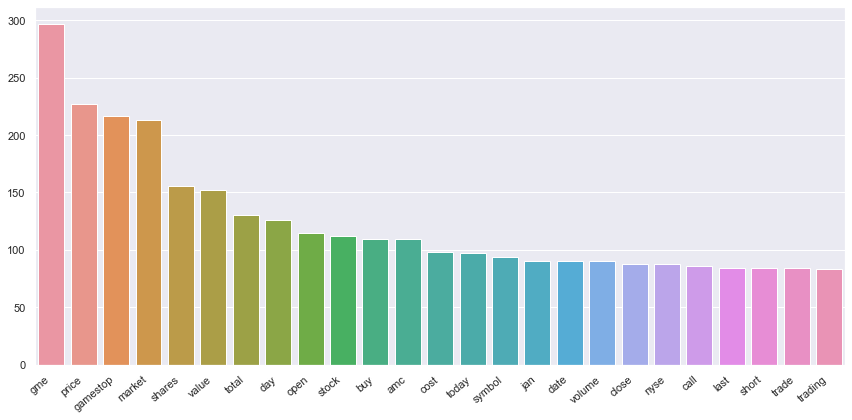

In [28]:
tokenize_image_text(data_with_image_text)

plot_most_frequent_words(most_frequent_words(data_with_image_text.image_text_tokens))

### Without 27.01 and 28.01

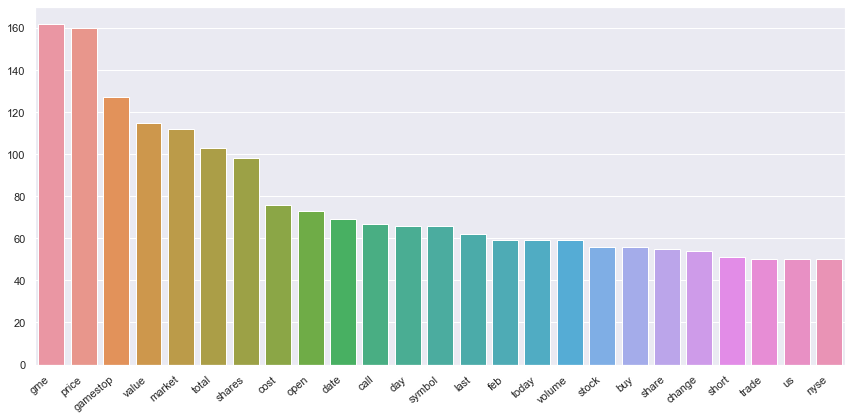

In [42]:
filtered = data_with_image_text[~(
    (data_with_image_text.created > 1611702000)
    & (data_with_image_text.created < 1611874799)
)]

plot_most_frequent_words(most_frequent_words(filtered.image_text_tokens))

## Capital letters

In [43]:
def count_capital_letters(text):
    text = str(text)
    return sum([1 for char in text if 91 > ord(char) > 64])

def capital_letters_ratio(text):
    text = str(text)
    alphacount = sum([1 for char in text if str(char).isalpha()])
    if alphacount == 0:
        return 0
    return count_capital_letters(text) / alphacount

In [47]:
data_with_image_text['image_text_capital_letters_count'] = data_with_image_text.apply(lambda x: count_capital_letters(x.image_text), axis=1) 
data_with_image_text['image_text_capital_letters_ratio'] = data_with_image_text.apply(lambda x: capital_letters_ratio(x.image_text), axis=1).apply(lambda x: np.around(x, 3))
data_with_image_text[['image_text', 'image_text_capital_letters_count', 'image_text_capital_letters_ratio']]

<ipython-input-47-1898b27ad6b4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_image_text['image_text_capital_letters_count'] = data_with_image_text.apply(lambda x: count_capital_letters(x.image_text), axis=1)
<ipython-input-47-1898b27ad6b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_image_text['image_text_capital_letters_ratio'] = data_with_image_text.apply(lambda x: capital_letters_ratio(x.image_text), axis=1).apply(lambda x: np.around(x, 3))


,image_text,image_text_capital_letters_count,image_text_capital_letters_ratio
11340,ASSETS Current assets: Cash and cash equivalen...,130,0.132
21116,TECH Intel’s incoming CEO says troubled chip m...,101,0.208
37093,STOCK Y COMPANY © LAST PRICE GME GameStopCorp ...,88,0.595
11956,INSG INSEEGO CORP = eae +8077 - a “ - ba ~ ~ o...,15,0.417
4818,ae | A B c D E F cS H I J K Lt M N ° P Q | Ins...,323,0.143
...,...,...,...
596,"Top Contributors, 2019-2020 (Move your cursor ...",45,0.176
32720,Symbol BB.TO Jan 29 2021 30 Call BB.TO Jan 29 ...,61,0.517
9453,547 @™MOB ONS wil GME Order Completed a e Your...,23,0.211
16660,Top Charts 4 1 Robinhood: Investing ~ for All ...,36,0.248


### Without 27.01 and 28.01

In [48]:
filtered['image_text_capital_letters_count'] = filtered.apply(lambda x: count_capital_letters(x.image_text), axis=1) 
filtered['image_text_capital_letters_ratio'] = filtered.apply(lambda x: capital_letters_ratio(x.image_text), axis=1).apply(lambda x: np.around(x, 3))
filtered[['image_text', 'image_text_capital_letters_count', 'image_text_capital_letters_ratio']]

<ipython-input-48-d17fc103c701>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['image_text_capital_letters_count'] = filtered.apply(lambda x: count_capital_letters(x.image_text), axis=1)
<ipython-input-48-d17fc103c701>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['image_text_capital_letters_ratio'] = filtered.apply(lambda x: capital_letters_ratio(x.image_text), axis=1).apply(lambda x: np.around(x, 3))


,image_text,image_text_capital_letters_count,image_text_capital_letters_ratio
11340,ASSETS Current assets: Cash and cash equivalen...,130,0.132
21116,TECH Intel’s incoming CEO says troubled chip m...,101,0.208
37093,STOCK Y COMPANY © LAST PRICE GME GameStopCorp ...,88,0.595
11956,INSG INSEEGO CORP = eae +8077 - a “ - ba ~ ~ o...,15,0.417
4818,ae | A B c D E F cS H I J K Lt M N ° P Q | Ins...,323,0.143
...,...,...,...
31570,TSLA 01/29/2021 1000.00 C ‘Action Quantity Pri...,32,0.330
15022,Minlele)| > -AAPL210129P126 > -AAPL210219C120 ...,62,0.473
34115,~* NOK eo $65.00 $65.00 $65.00 NOKIA OY] ADR S...,29,0.879
3341,LFIN INSTRUMENT 4 FEE RATE RBTRT POSITION MKT ...,52,0.963


In [7]:
ocr = MemeOCR()
result = ocr.recognize(path.join(temp_dir, 'a.png'))

In [8]:
len(result)

1

In [9]:
result

["Latin term Latin synonym UK English US English English synonym Other 381 | Systemata integrantia Integrating systems _| Integrating systems 3852 _| Glandulae endocrinae Endocrine glands Endocrine glands Systema endocrnum Glandulae sine ductibus; Glandulae endocrinales; Glandulae clausae Endnote 562 3653 ES EE ypophysis Hypophysis Endnote 563 3854 | Giandula pituitaria Pituitary gland Pituitary gland Endnote 564 3855 | Adenohypophysis ‘Adenohypophysis ‘Adenohypophysis 3856 | Pars tuberalis hypophysis Pars tuberalis of hypophysis, Pars tuberalis of hypophysis, Pars infundibularis ‘adenohypophysis; Pars tuberalis hypoohyseos Endnote 565 3857 | _ Pars distalis hypophysis Lobus anterior glandulae pituitariae | Pars distalis of hypophysis, Pars distalis of hypophysis ‘Anterior lobe of pitultary gland Pars anterior adenohypophysis; Lobus glandularis hypophyseos Endnote 566 3858 | Pars intermedia hypophysis Pars intermedia of hypophysis Pars intermedia of hypophysis Pars intermedia hypophyse